## Correlation plot


In [1]:
# KHOA NOTE: Remove #4
usedSubjects=[1,2,3,4,5,6,7,8,9,10,11,12,13,16,19,20]
subjectID=2
subjectID=subjectID-1

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.io



def readCSV(fileName):
    res=np.array(pd.read_csv(fileName,header=None,delimiter='\t'))
    return res

def readTXT(fileName):
    res=np.array(pd.read_csv(fileName,header=None,delimiter='\t'))
    return res

noSubjectNum=0
# for i in range(noSubjectNum):
i=subjectID
Fn=f"OK00{i+1}" if i < 9 else f"OK0{i+1}"
print(Fn)


GaitPodFn=Fn+"_vel_imu.mat"
HRFn=Fn+"_HR.csv"
oxygenFn=Fn+"_Oxycon.txt"
print(GaitPodFn)


HR_dir="HR data/"
oxygen_dir="OxyCon data/"
gaitpod_dir="GaitPod data/"


HRFn=HR_dir+HRFn
oxygenFn=oxygen_dir+oxygenFn
GaitPodFn=gaitpod_dir+GaitPodFn

OK002
OK002_vel_imu.mat


## Define cutoff time

In [3]:
# -1 cutoff time means NaN
# cut-off times based on measurement memos (in seconds)
GaitPod_CutOff_Times = [565, 358, 318, 672, 700, 660, 594, 280, 533, 365, 474, 1549, 530, -1, -1, 387, -1, -1, 375, 350];
# cut-off times based on cross-correlation of normalized VO2 and HR data (in seconds)
HR_CutOff_Times = [519, 530, 409, 505, 450, 502, 490, 430, 528, 546, 365, 712, 401, -1, -1, 390, -1, -1, 387, 410];

## Define resampling time 

In [4]:
# Sampling time for heart rate (in seconds)
HR_sampling_time=5

# Sampling time for oxygen (in seconds)
Oxygen_sampling_time=5

# Sampling time for gaitpod (in seconds)
GaitPod_sampling_time=5

[  32.   35.   38. ... 5672. 5675. 5677.]
[  32.   35.   38. ... 5672. 5675. 5677.]
[760, 761, 762, 763, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 960]


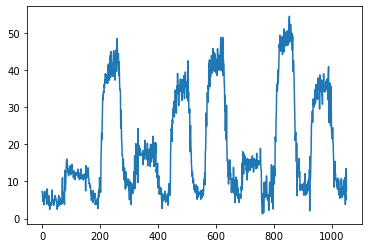

In [5]:
oxygen_data=np.array(np.squeeze(pd.read_csv(oxygenFn,header=6,delimiter='\t')))
oxygen_data_reconstruct=np.zeros(np.shape(oxygen_data))

# Define a custom function to convert string with comma to float
iter = 1

def check_duplicates(arr):
    unique_values, counts = np.unique(arr,return_counts=1)
    duplicated_vaules = unique_values[counts>1]
    print(duplicated_vaules)
    for duplicate in duplicated_vaules:
        indices = np.where(arr == duplicate)[0]
        print(f"Element {duplicate} is duplicated at indices: {indices.tolist()}")

def comma_to_float(string):
    string=str(string)
    if len(string) == 0 or '-' in string or '#' in string:
        return -100
    # Replace comma with dot and convert to float
    if ',' in string:
        return np.float32(string.replace(',', '.'))
    else:
        return np.float32(string)

def remove_outline(array,outline_threshold):
    for i,row in enumerate(array):
        if row[1]>outline_threshold:
            print(f"Delete outline at it {i}")
            np.delete(array,i,0)
    return array


oxygen_data_reconstruct=np.zeros(np.shape(oxygen_data))
iter=0

for row in oxygen_data:
    oxygen_data_reconstruct[iter][0]=row[0]
    oxygen_data_reconstruct[iter][1]=comma_to_float(row[1])
    iter+=1
    
oxygen_data_reconstruct=np.array(oxygen_data_reconstruct)

print(oxygen_data_reconstruct[:,0])

outline_threshold=200
for i,row in enumerate(oxygen_data_reconstruct):
    if row[1]>outline_threshold:
#         print(f"Delete outline at it {i}")
        oxygen_data_reconstruct=np.delete(oxygen_data_reconstruct,i,0)

## REMOVE MISSING DATA
mask=oxygen_data_reconstruct[:, 1] >= 0
oxygen_data_reconstruct=oxygen_data_reconstruct[mask]

## OXYGEN IS RECORDED AT AVERAGE OF 3 seconds
timestamps=oxygen_data_reconstruct[:,0]
print(timestamps)
firstSec=timestamps[0]
lastSec=timestamps[-1]

## DO WE NEED SAMPLING FOR 3SECONDS ?? IT WILL RESULT IN 2 MISSING DATA INTERVALS
oxygenResamplingIdx = np.arange(firstSec, lastSec, Oxygen_sampling_time)
oxygen_sampling=np.interp(oxygenResamplingIdx,timestamps,oxygen_data_reconstruct[:,1])

## ===== FOR SUBJECT 2, REMOVE NAN AND ZERO ENTRIES
reconstruct_index=[]
if subjectID==1:
    for i,data in enumerate(oxygen_sampling):
        if data < 1:
            reconstruct_index.append(i)
    print(reconstruct_index)
    oxygen_sampling = [value for index,value in enumerate(oxygen_sampling) if index not in reconstruct_index]

plt.plot(oxygen_sampling)

## Heart rate processing


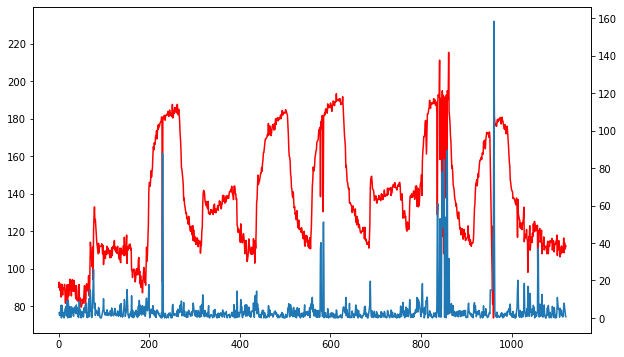

In [6]:
HR_CutOff_Time=HR_CutOff_Times[subjectID]
# print(HR_CutOff_Time)
HR_data=np.squeeze(readCSV(HRFn))
# HR_data=np.char.split(np.squeeze(readCSV(HRFn)),sep=";")
HR_data_stack=list()
for i in range(len(HR_data)):
    HR_data_tmp=HR_data[i].split(";")
#     print(HR_data_tmp)
    HR_data_stack.append(HR_data_tmp)
HR_data_stack=np.vstack(HR_data_stack)


## Remove HR data with len=0
arr_list=HR_data_stack.tolist()
HR_data_stack=[item for item in arr_list if len(item[0]) > 0 and len(item[1]) > 0]
HR_data_stack=np.array(HR_data_stack).astype(np.float32).squeeze()

HR_data_stack[:,0]=HR_data_stack[:,0]/1000


HRFirstEle=HR_data_stack[0,0]
HRLastEle=HR_data_stack[-1,0]
# print(HRFirstEle)
# print(HRLastEle)
HR_sampling_index=np.arange(HRFirstEle, HRLastEle, HR_sampling_time)

HR_sampling=np.interp(HR_sampling_index,HR_data_stack[:,0],HR_data_stack[:,1])

##=========== Cut off HR data
HR_sampling_cut=HR_sampling[HR_CutOff_Time:]

# plt.plot(HR_sampling_cut,'g')
HR_remove_index=[]
# print(HR_sampling_cut)

##=========== READY TO PLOT
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()


if subjectID==1:
    for idx,hr_data_tmp in enumerate(HR_sampling_cut):
        if hr_data_tmp < 70:
            HR_remove_index.append(idx)
    HR_sampling_cut=[value for index,value in enumerate(HR_sampling_cut) if index not in HR_remove_index ]
    
    HR_sampling_cut=np.array([value for index,value in enumerate(HR_sampling_cut) if index not in reconstruct_index])
elif subjectID==9:
    pass
    
# Detect outline data and take mean of window slide
data=pd.Series(HR_sampling_cut)
HR_smooth=HR_sampling_cut.copy()

ax1.plot(HR_sampling_cut,'r')
threshold = 25

plt.plot(np.abs(data.diff()))
outliers=np.abs(data.diff())>threshold
for i in(range(len(outliers))):
    pass

[188.17687189 187.693833   187.33429347 187.09825331 186.9857125
 186.99667105 187.13112896 187.38908624 187.77054287 188.27549886
 188.90395422 189.65590893 190.531363   191.53031644 192.47540084
 193.18924785 193.67185744 193.92322962 193.9433644  193.73226177
 193.28992173 192.61634428 191.71152942 190.57547715 189.20818748
 187.6096604  185.77989591]
[188.40347672 187.92396981 188.41249447 187.45660491 188.37918381
 188.08512338 187.9750609  188.05278124 187.78718822 189.04686882
 189.03185713 189.99706466 191.65579839 191.71916926 192.76256982
 193.95917792 193.86621478 195.53839976 194.37476283 194.58612632
 194.11235051 193.64127105 192.13960026 191.41248182 190.37864841
 188.14389414 186.22372055]
0            NaN
1       0.030496
2      -0.014154
3      -0.033423
4       0.037322
          ...   
1116   -0.067922
1117    0.049354
1118   -0.029671
1119    0.009606
1120    0.005820
Length: 1121, dtype: float64


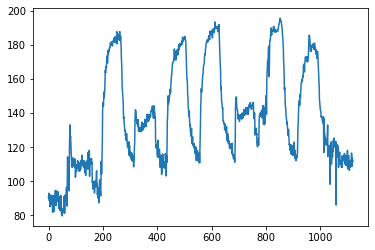

In [14]:
if subjectID==1:
    data[229:230] = data[578:585] = data[835:862] = data[953:962] = None

    data_interpolated=data.interpolate(method='polynomial',order=2)
    percentChangeData=data_interpolated.pct_change()
    rollingStd=percentChangeData.rolling(10).std()

    eps_values = np.random.uniform(0, 1, size=(230 - 229,))
    data_interpolated[229:230] = (rollingStd[228] * eps_values + 1) * data_interpolated[229:230]

    eps_values = np.random.uniform(0, 1, size=(585 - 578,))
    data_interpolated[578:585] = (rollingStd[577] * eps_values + 1) * data_interpolated[578:585]

    eps_values = np.random.uniform(0, 1, size=(862 - 835,))
    print(np.array(data_interpolated[835:862]))
    data_interpolated[835:862] = (rollingStd[834] * eps_values + 1) * data_interpolated[835:862]
    print(np.array(data_interpolated[835:862]))
    eps_values = np.random.uniform(0, 1, size=(962 - 953,))
    data_interpolated[953:962] = (rollingStd[952] * eps_values + 1) * data_interpolated[953:962]

    plt.plot(data_interpolated)
    
    HR_final=data_interpolated

    print(percentChangeData)


In [8]:
# for i in outliers.index:
#     HR_smooth[i] = np.mean(data[i-10:i-5])

p1, = ax1.plot(HR_smooth)
data_smooth=pd.Series(HR_smooth)
# print(data_smooth)
## TODO: ADD INTERPOLATE OR GET RID OF 959 960 961 962
# plt.plot(np.abs(.diff()),'g')
p2, = ax2.plot(np.abs(data_smooth.diff()))
threshold_=19
outliers_=np.abs(data_smooth.diff())>threshold_
remove_index_=list()
for i in range(len(outliers_)):
    if outliers_[i]:
        remove_index_.append(i)
#         print(i)
#         print(outliers_[i])

# p1, = ax1.plot(data, 'r', label='v_lon_match')

window_size=2
z_list=[]
# z_scores = data.rolling(window_size).apply(lambda x: np.abs((x - x.mean()) / x.std()))

In [9]:
HR_smooth[959:963]=None
# print(HR_smooth[~np.array(remove_index_)])

## Gaitpod processing

False
False


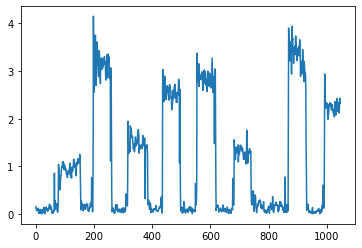

In [10]:
gaitpod_data = scipy.io.loadmat(GaitPodFn)

v_lon=gaitpod_data['V_lon']
v_d=gaitpod_data['v_d']

gaitpod_CutOff_Time=GaitPod_CutOff_Times[subjectID]
gp_new_idx=gaitpod_CutOff_Time*400


## ===== Remove NaN data from v_lon and v_d
if (np.isnan(v_d).any() or np.isnan(v_lon).any()):
    v_lon=v_lon[~np.isnan(v_lon)]
    v_d=v_d[~np.isnan(v_d)]

## ===== CUT OF GAITPOD DATA
v_lon=v_lon[gp_new_idx:,:]
v_d=v_d[gp_new_idx:,:]

N=len(v_lon)
idx=np.arange(0,N,400*GaitPod_sampling_time)

v_lon_match = pd.DataFrame(v_lon, index = None)
# print(len(v_lon_match))
v_lon_match = v_lon_match.rolling(400).mean()
# print(v_lon_match.loc[idx])
v_lon_match=v_lon_match.iloc[idx].values
# Remove first Nan
v_lon_match=v_lon_match[1:]

v_d_match = pd.DataFrame(v_d)
v_d_match = v_d_match.rolling(400).mean()
v_d_match=v_d_match.iloc[idx].values
v_d_match=v_d_match[1:]

print(np.isnan(v_lon_match).any())
print(np.isnan(v_d_match).any())
# print(v_lon_match[0:400])

plt.plot(v_lon_match)
if subjectID==1:
    v_lon_match=np.array([value for index,value in enumerate(v_lon_match) if index not in reconstruct_index])
    

In [11]:
# plt.plot(v_lon_match)
# plt.plot(v_d_match)

In [12]:
# plt.plot(v_lon_match)
# plt.plot(oxygen_sampling)
# plt.plot(HR_sampling_cut)

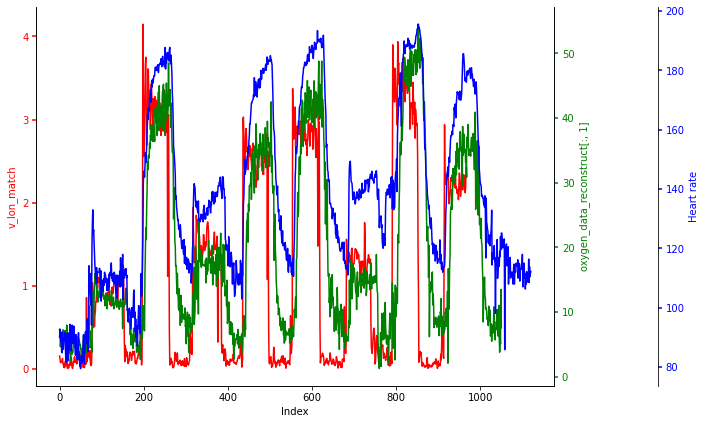

In [15]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
fig, ax1 = plt.subplots(figsize=(10, 6))


ax2 = ax1.twinx()
ax3 = ax1.twinx()


##============ PLOT 3 DATAS
p1, = ax1.plot(v_lon_match, 'r', label='v_lon_match')
p2, =ax2.plot(oxygen_sampling,'g',label='oxygen_sampling_5s')
p3,=ax3.plot(HR_final, 'b', label='HR_sampling')


ax1.set_xlabel('Index')
ax1.set_ylabel('v_lon_match', color='r')
ax1.yaxis.label.set_color(p1.get_color())

# Create the second plot with secondary y-axis
ax2.set_ylabel('oxygen_data_reconstruct[:, 1]', color='g')
ax2.yaxis.label.set_color(p2.get_color())


# Create the third plot with additional y-axis on the right side
ax3.spines["right"].set_position(("axes", 1.2))
make_patch_spines_invisible(ax3)
ax3.spines["right"].set_visible(True)
ax3.set_ylabel('Heart rate')
ax3.yaxis.label.set_color(p3.get_color())
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position('right')


# Adjust spacing between subplots
fig.tight_layout()

# Display the legend
# handles1, labels1 = ax1.get_legend_handles_labels()
# handles2, labels2 = ax2.get_legend_handles_labels()
# handles3, labels3 = ax3.get_legend_handles_labels()
# plt.legend(handles1 + handles2 + handles3, labels1 + labels2 + labels3)

# Remove the top index axis
# ax1.tick_params(axis='x', top=False)

tkw = dict(size=4, width=1.5)
ax1.tick_params(axis='y',colors=p1.get_color(),**tkw)
ax2.tick_params(axis='y',colors=p2.get_color(),**tkw)
ax3.tick_params(axis='y',colors=p3.get_color(),**tkw)

ax1.spines[['top']].set_visible(False)
ax2.spines[['top']].set_visible(False)
ax3.spines[['top']].set_visible(False)

# Show the plot
plt.show()


## Calculate correlation

In [ ]:
figCorrName=f"Subject_{subjectID+1}_corr.jpg"
print(figCorrName)

In [ ]:
import seaborn as sns

min_len=min(len(v_lon_match),len(oxygen_sampling),len(HR_sampling_cut))
v_lon_match=v_lon_match[:min_len].squeeze()
oxygen_sampling=oxygen_sampling[:min_len]
HR_sampling_cut=HR_sampling_cut[:min_len]

print(np.shape(v_lon_match))
print(np.shape(oxygen_sampling))
print(np.shape(HR_sampling_cut))

data_frame=pd.DataFrame({"Longitudinal_Velocity":v_lon_match,"Heart_Rate":HR_sampling_cut,"Oxygen":oxygen_sampling})
print(data_frame)

columns_of_interest = ['Longitudinal_Velocity','Heart_Rate','Oxygen' ]
subset_df = data_frame[columns_of_interest]
correlation_matrix = subset_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool),k=1)
ax=sns.heatmap(correlation_matrix, mask=mask,annot=True, cmap='coolwarm', annot_kws={'size': 15})
ax.figure.axes[-1].yaxis.label.set_size(12)

plt.xticks(fontsize=12,rotation=45)
plt.yticks(fontsize=12,rotation=45)
plt.title(f"Subject_{subjectID+1} Correlation Matrix",size=20,loc="center",fontdict={'weight': 'bold'},y=1.05)
fig = plt.gcf()
fig.set_size_inches(16, 12)

plt.savefig(figCorrName)
plt.show()


## Save figure

In [ ]:
x = data_frame.index  # Assuming the index is suitable for the x-axis
y1 = data_frame['Longitudinal_Velocity']
y2 = data_frame['Oxygen']
y3 = data_frame['Heart_Rate']
plt.plot(x, y1, label='Longitudinal Velocity')
plt.plot(x, y2, label='Oxygen')
plt.plot(x, y3, label='Heart Rate')
plt.title('Data Plot')
plt.xlabel('Index')
plt.ylabel('Values')

# Show legend
plt.legend()

# Display the plot
plt.show()

## Calculate steps then speed, speed change, step duration and vertical oscillation distance amplitude

In [ ]:
import scipy

min_len=min(len(v_lon_match),len(oxygen_sampling),len(HR_sampling))
v_lon_match=v_lon_match[:min_len]
oxygen_sampling=oxygen_sampling[:min_len]
HR_sampling=HR_sampling[:min_len]


windowStart = 1
windowEnd = len(v_d_match)

vertVel = v_d_match[windowStart - 1:windowEnd]
plt.plot(vertVel)

# KHOA NOTE: Remove Detrend
vertVel_d = scipy.signal.detrend(vertVel)
vertVel_d = vertVel
# print(np.isnan(vertVel_d).any())
maxV = np.max(vertVel_d)
thresh = 0.05 * maxV
a = False
b = False
front = 0
back = 0


cwi = 0
print("Size vertVel_d:")
print(vertVel_d.shape)
print("threshold:")
print(thresh)
while True:
    cwi += 1
    if cwi == 50:
        print('Detrending terminated after 50 iterations. Apparently stuck in local optima.')
        break
#     print(vertVel_d[0])
#     print(vertVel_d[1])
    if np.abs(vertVel_d[0]) > thresh or vertVel_d[0] > vertVel_d[1]:
        vertVel_d = vertVel_d[2:]
        vertVel_d = vertVel_d - np.mean(vertVel_d)
        front += 2
        a = False
    else:
        a = True
    if vertVel_d[-1] > thresh or vertVel_d[0] > vertVel_d[1]:
        vertVel_d = vertVel_d[:-3]
        vertVel_d = vertVel_d - np.mean(vertVel_d)
        back += 3
        a = False
        b = False
    else:
        b = True
    if a and b:
        break
print("Front:")
print(front)
print("Back:")
print(back)

v_lon = v_lon[windowStart + front-1 : windowEnd - back]
v_d = v_d[windowStart + front-1 : windowEnd - back]
windowEnd_r =np.arange(front-1,windowEnd)
back_r = back

steps = []
if vertVel_d[0] > 0:
    steps.append(1)

count = 0
for i in range(len(vertVel_d) - 1):
    if vertVel_d[i] < 0 and vertVel_d[i + 1] > 0:
        count += 1
        steps.append(i + 1)
print('Count: ')
print(count)
print('Length Steps')
print(len(steps))

stepCount = len(steps) - 1
print("Step count:")
print(stepCount)


# plt.plot(vertVel)
# plt.plot(vertVel_d)

In [ ]:
import scipy

vertVel_d=scipy.signal.detrend(vertVel)
plt.plot(vertVel_d)
maxV = np.max(vertVel_d)
thresh = 0.05 * maxV
a = False
b = False
front = 0
back = 0


cwi = 0
print("Size vertVel_d:")
print(vertVel_d.shape)
print("threshold:")
print(thresh)
while True:
    cwi += 1
    if cwi == 50:
        print('Detrending terminated after 50 iterations. Apparently stuck in local optima.')
        break
#     print(vertVel_d[0])
#     print(vertVel_d[1])
    if np.abs(vertVel_d[0]) > thresh or vertVel_d[0] > vertVel_d[1]:
        vertVel_d = vertVel_d[2:]
        vertVel_d = vertVel_d - np.mean(vertVel_d)
        front += 2
        a = False
    else:
        a = True
    if vertVel_d[-1] > thresh or vertVel_d[0] > vertVel_d[1]:
        vertVel_d = vertVel_d[:-3]
        vertVel_d = vertVel_d - np.mean(vertVel_d)
        back += 3
        a = False
        b = False
    else:
        b = True
    if a and b:
        break
print("Front:")
print(front)
print("Back:")
print(back)

v_lon = v_lon[windowStart + front-1 : windowEnd - back]
v_d = v_d[windowStart + front-1 : windowEnd - back]
windowEnd_r =np.arange(front-1,windowEnd)
back_r = back

steps = []
if vertVel_d[0] > 0:
    steps.append(1)

count = 0
for i in range(len(vertVel_d) - 1):
    if vertVel_d[i] < 0 and vertVel_d[i + 1] > 0:
        count += 1
        steps.append(i + 1)
print('Count: ')
print(count)
print('Length Steps')
print(len(steps))

stepCount = len(steps) - 1
print("Step count:")
print(stepCount)

In [ ]:
vertVel_d=scipy.signal.detrend(vertVel_d)
plt.plot(vertVel_d)

## Calculate correlation

In [ ]:


# print(np.shape(v_lon_match))
# print(np.shape(oxygen_sampling))
# print(np.shape(HR_sampling))

data_frame=pd.DataFrame({"Longitudinal_Velocity":v_lon_match,"Oxygen":oxygen_sampling,"Heart_Rate":HR_sampling})
print(data_frame)

## Plot 2 outlined points

In [ ]:
a=resStack[:,0:2]
b=a[abs(a[:,0]-a[:,1])>20]
print(b)
diff=b[:,0]-b[:,1]
print(diff)
c=np.mean([b[:,0],b[:,1]],axis=0)
print(c)

plt.figure(figsize=(3,2.8))
#plt.subplot(2,1,1)
plt.scatter(c[0],diff[0],color="green")
#plt.xlim(18.5,19)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)

plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)


fig = plt.gcf()
fig.savefig('dots1'+'.jpg',bbox_inches='tight')
#plt.subplot(2,1,2)
plt.show()



In [ ]:
plt.figure(figsize=(3.0,2.8))
plt.scatter(c[1],diff[1],color="orange")
#plt.xlim(15,25)
#plt.ylim(-25,-30)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)

plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

fig = plt.gcf()
fig.savefig('dots2'+'.jpg',bbox_inches='tight')
plt.show()

## Save the final figure

In [ ]:
from PIL import Image, ImageDraw, ImageFilter
bigIm=Image.open('BlandAltman_all_subjects.jpg')
dot1=Image.open('dots1.jpg')
dot2=Image.open('dots2.jpg')

back_im = bigIm.copy()
back_im.paste(dot1,(180,750))
back_im.paste(dot2,(180,150))
#back_im.show()
back_im.save('final.jpg',qualit=95)

## References plot from built-in library

In [ ]:
import statsmodels.api as sm
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(VO2_hat,VO2,ax=ax)
plt.show()
#print(mean)